This notebook reads the csv with the classifications of the different grids and then trains a CNN using fastai2. As a last step features are extracted which are then used for a ridge regression/random forest in R.

Start by installing fastai.

In [1]:
!pip install -Uq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 7.8 MB/s eta 0:00:00


Import necessary packages.

In [2]:
import torch
from fastai.vision import *
from fastai.vision.all import *
import pandas as pd
from google.colab import drive
import shutil

Mount Google Drive to access the satellite images and the csv containing the classes of the images.

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Create a variable with the main directory we need, the data on the Google Drive.

In [4]:
gdrive_data_path = '/content/gdrive/MyDrive/adb_poverty_elearning_module/data'

Now we read the csv, add a new column called "file_name" that consists of a six digit ID (with leading zeroes) and the suffix "jpg".

In addition, we make sure that our csv only contains grids for which we actually have images (e.g. there might be no images with less than 60% cloud cover in 2019 for a grid).

We output the first ten rows of the dataset to see what it looks like.

In [5]:
grids_csv = gdrive_data_path + "/grids/indonesia_grids_classified.csv"
s2_path = gdrive_data_path + "/satellite_imagery/idn_east_java_s2_2019"

train_dataset = pd.read_csv(grids_csv)

train_dataset["file_name"] = train_dataset.apply(lambda x: f"{{:06d}}.jpg".format(x["id"]), axis=1)

image_files = os.listdir(s2_path)

train_dataset = train_dataset[train_dataset.file_name.isin(image_files)]

train_dataset.head(10)

id           X         Y     adm4_code  nl_value   population  nl_class  \
0   1  114.593797 -5.063259  ID3529250048  0.154724   373.898163         1   
1   2  114.593797 -5.084956  ID3529250048  0.143880   178.519989         1   
2   3  114.420219 -5.432113  ID3529250048  0.138115   623.319580         1   
3   4  114.420219 -5.453811  ID3529250048  0.139304   337.262573         1   
4   5  114.398521 -5.540600  ID3529250048  0.213877   474.031555         1   
5   6  114.398521 -5.562297  ID3529250048  0.321316   709.980469         1   
6   7  114.420219 -5.562297  ID3529250048  0.415459  1262.903198         1   
7   8  114.441916 -5.562297  ID3529250048  0.274093   989.766602         1   
8   9  112.641040 -5.735876  ID3525179904  0.579765  1222.048706         1   
9  10  112.662737 -5.735876  ID3525179904  0.588171  1270.645996         1   

    file_name  
0  000001.jpg  
1  000002.jpg  
2  000003.jpg  
3  000004.jpg  
4  000005.jpg  
5  000006.jpg  
6  000007.jpg  
7  000008.jpg  
8  000009.jpg  
9  000010.jpg

Print an overview for the dataset, including infos on the different columns and on the sample itself.

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          100 non-null    int64  
 1   X           100 non-null    float64
 2   Y           100 non-null    float64
 3   adm4_code   100 non-null    object 
 4   nl_value    100 non-null    float64
 5   population  100 non-null    float64
 6   nl_class    100 non-null    int64  
 7   file_name   100 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 7.0+ KB


Before we can start training the model, we need to define an [ImageDataLoader](https://docs.fast.ai/vision.data.html#imagedataloaders).

There are different parameters we need to set:


1.   df: Name of the data frame that contains information on the observations.
2.   path: Path pointing to the folder containing the images.
3.   valid_pct: Share of observations used for validation (as opposed to training).
4.   seed: Set a seed to make sure training and validation split are the same for different runs.
5.   fn_col: Name of the column that has the file name (of an image).
6.   label_col: Name of the column that contains the classification of an image (1 - low night light intensity, 2 - medium, 3 - high).
7.   bs: Batch size, the number of observations processed each round.
8.   num_workers: Number of workers, i.e. number of processes.
9.   batch_tmfs: Batch transformations applied to the images.



In [7]:
data = ImageDataLoaders.from_df(
    df = train_dataset,
    path = s2_path,
    valid_pct = 0.2,
    seed = 42,
    fn_col = "file_name",
    label_col = "nl_class",
    bs = 32,
    num_workers = 5,
    batch_tfms=Normalize.from_stats(*imagenet_stats))

Show a batch of images including the corresponding classes.

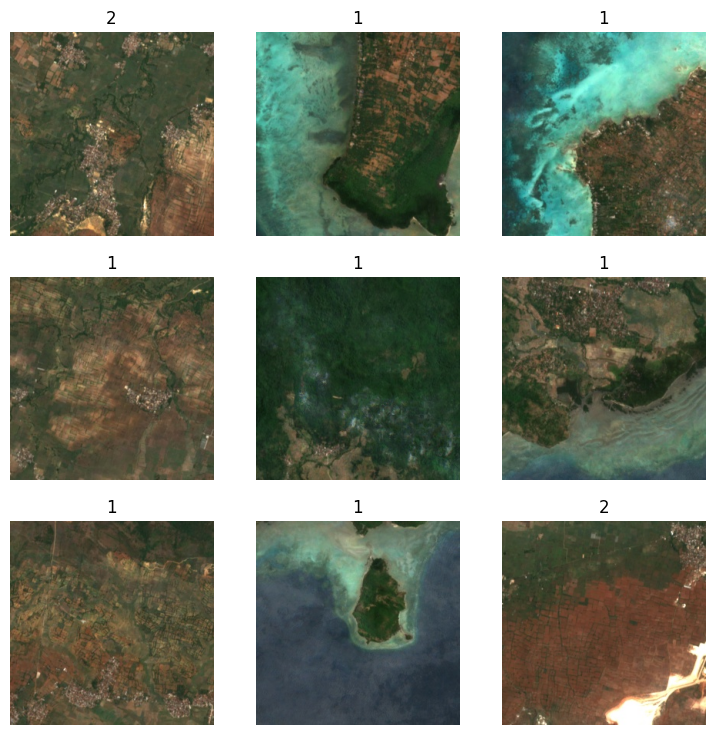

In [8]:
data.show_batch()

# Learning rate finder.

In neural networks the learning rate specifies how fast or slow a model "learns" (i.e. adjusts the different parameters). There is no universal learning rate that one can use for different datasets and problems as the optimal learning rate differs across problems and datasets.

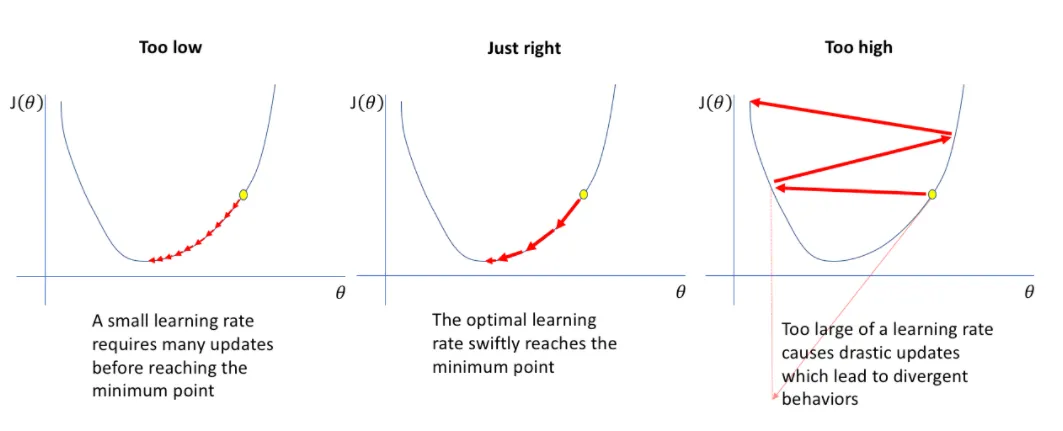

Source: [medium.com](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036)

Fortunately, fastai offers a learning rate finder that helps to specify the learning rate.

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


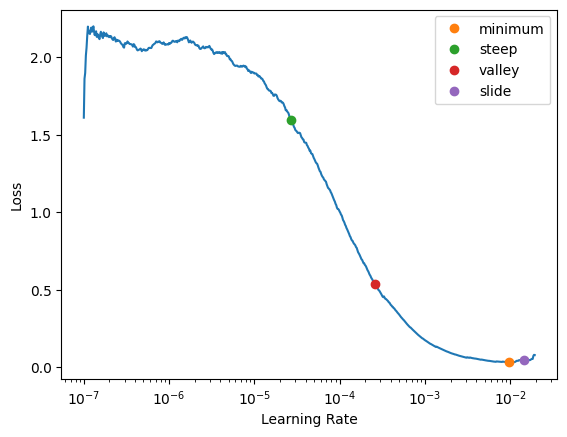

In [9]:
learner = vision_learner(dls = data,
                         arch = resnet34)

learning_rates = learner.lr_find(num_it=1000, suggest_funcs=(minimum, steep, valley, slide))

The graph above can be divided into three zones:


1.   Shallow zone, where changing the learning rate has a minimal effect on loss (between 10e-07 and 10e-5).
2.   Linear zone, where we observe a quick drop in the loss function (between 10e-05 and 10e-03).
3.   Divergent zone, where the learning rate is too high, resulting in loss to bounce and ultimately diverge from the local minima (learning rate above 10e-02).

A good rule of thumb is to use a learning rate which is one order of magnitude less than the minimum of the loss (in the graph above this corresponds to "valley").

Per default most layers are frozen when using vision_learner. The idea is that our problems are generalizable to the point where the first layers will be the same across problems. Hence, we focus on training the last layers.

We use a SaveModelCallback to stick to the model with the best validation loss. If an epoch leads to a model with a smaller loss, we switch to that model, otherwise we keep the earlier model stored as "best one" (which we will use later on to extract the features for the images).

In [10]:
learner.fit_one_cycle(10, learning_rates.valley,
                      cbs=SaveModelCallback (monitor='valid_loss', min_delta=0.0,
                                             fname='resnet34_long_training_java_grids_test_part_1', every_epoch=False, at_end=False,
                                             with_opt=True, reset_on_fit=True)
                     )

Better model found at epoch 0 with valid_loss value: 1.6364095211029053.
Better model found at epoch 1 with valid_loss value: 1.56793212890625.
Better model found at epoch 2 with valid_loss value: 1.5375398397445679.
Better model found at epoch 3 with valid_loss value: 1.5047193765640259.
Better model found at epoch 4 with valid_loss value: 1.4012272357940674.
Better model found at epoch 5 with valid_loss value: 1.206505537033081.
Better model found at epoch 6 with valid_loss value: 1.066641092300415.
Better model found at epoch 7 with valid_loss value: 1.0012067556381226.
Better model found at epoch 8 with valid_loss value: 0.9572571516036987.
Better model found at epoch 9 with valid_loss value: 0.9409432411193848.


Check confusion matrix to see how well our model classifies the different images into the three classes. We would like to see as many observations on the main diagonal as possible.

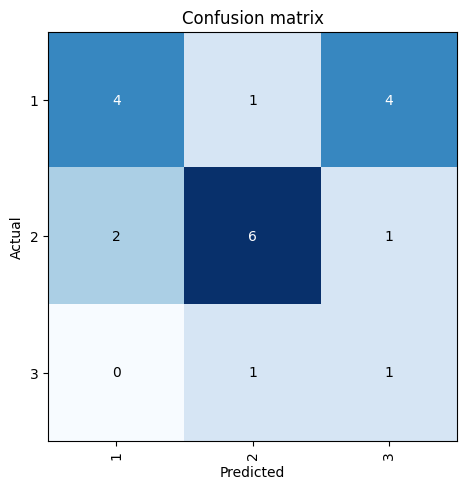

In [11]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

Plot some results.

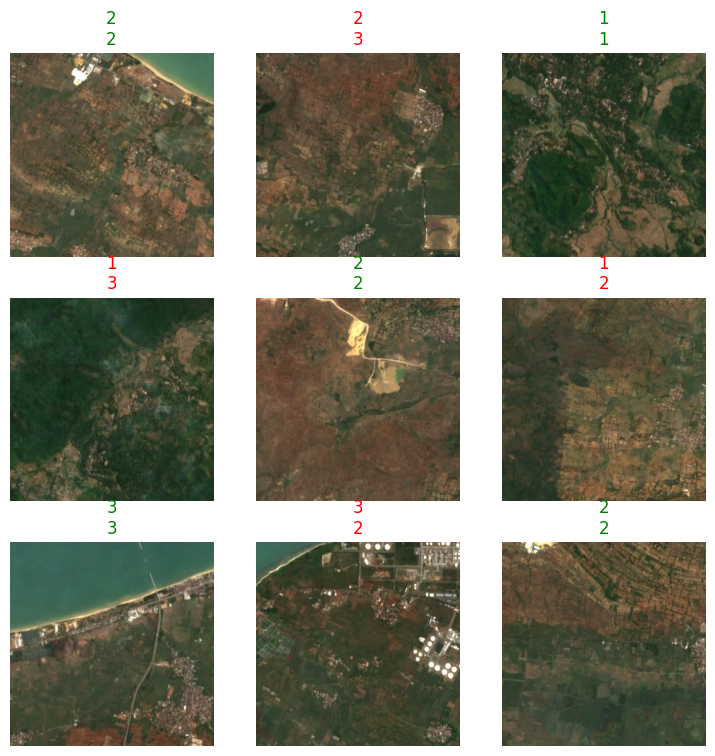

In [12]:
learner.show_results(max_n=9)

Plot the 9 images with the highest losses (starting with the highest). In addition, predicted and actual class are also shown.

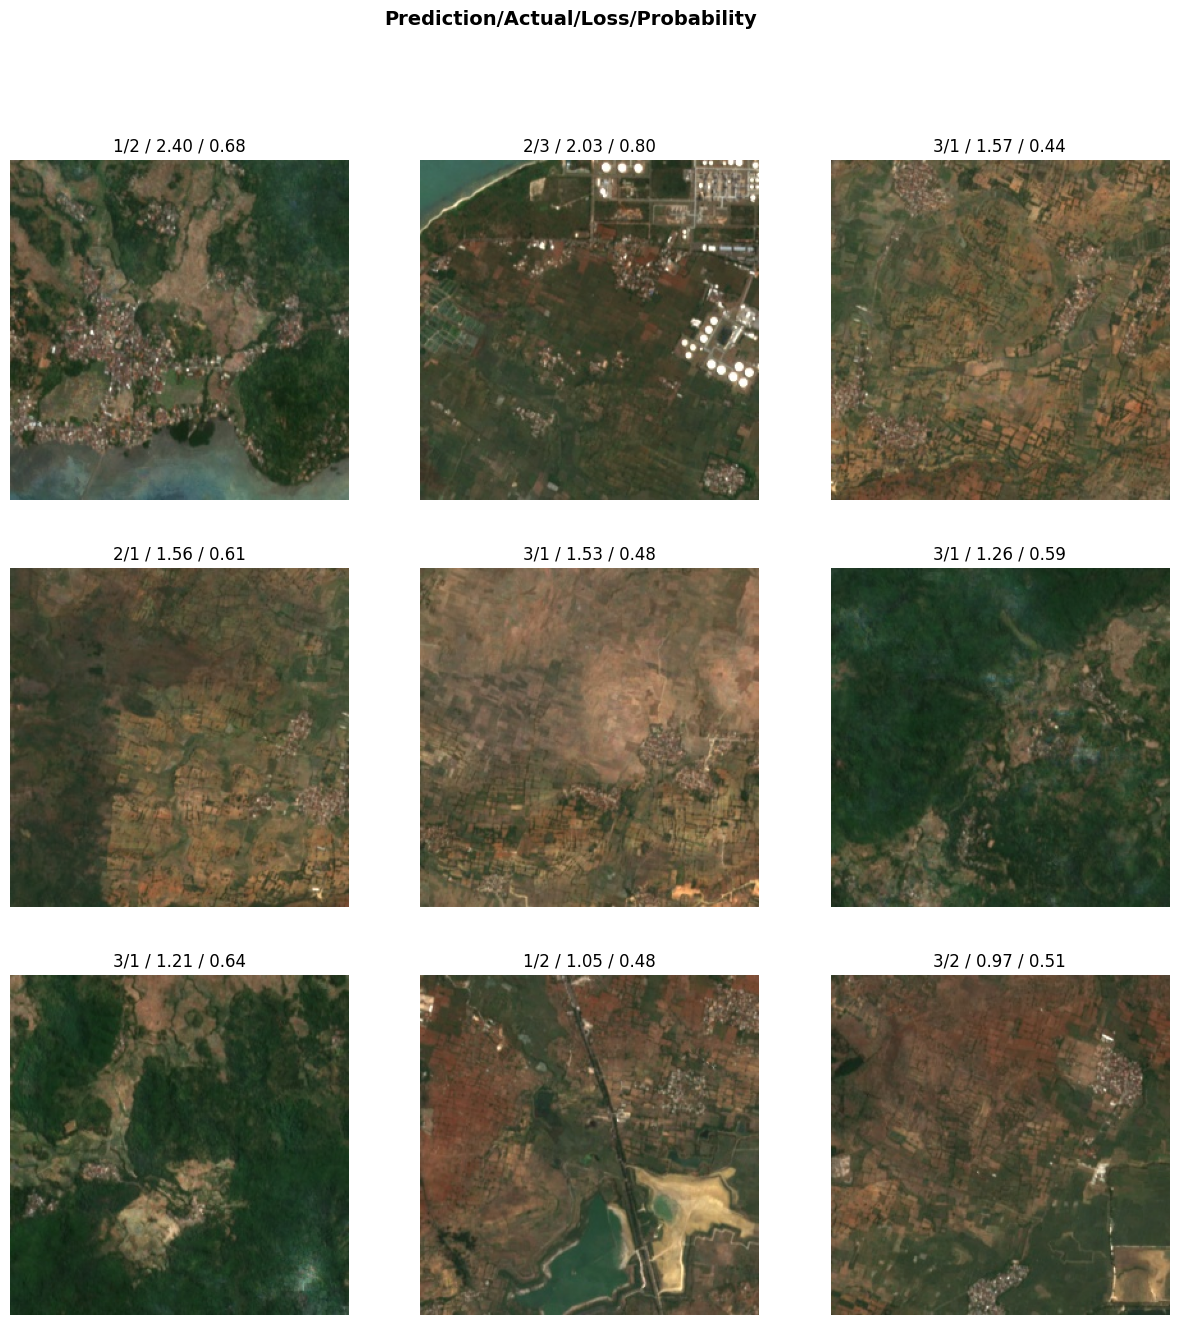

In [13]:
interp.plot_top_losses(9, figsize=(15,15), largest=True)

Let's have a look at our model.

In [14]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Remove last (linear) layer to get features instead of classes. We are not interested in the night light classification itself, but in the features that the network identifies.

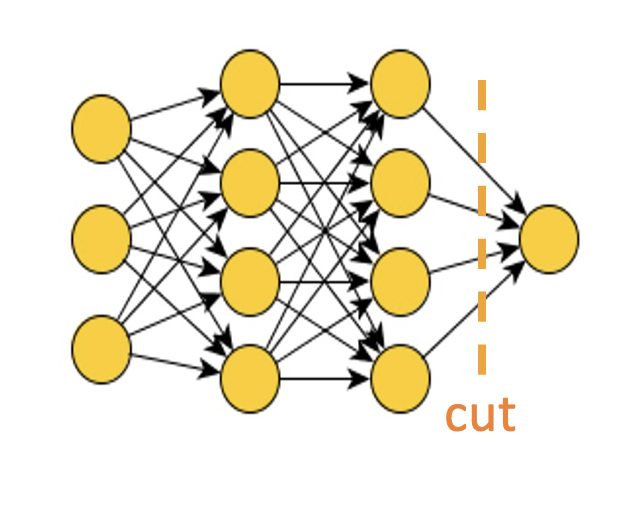

In [15]:
learner.model[-1] = cut_model(learner.model[-1], -1)

Extract features for all images in our dataset using the trained model.

In [16]:
features_out = np.empty((len(train_dataset["file_name"]), 512))
features_out_img = train_dataset["file_name"]
imagery_path = s2_path

# Loop through the images and extract the features.
for i, path_i in enumerate(features_out_img):
    # Open the image with the fastai open image function.
    temp_img = load_image(os.path.join(imagery_path, path_i))
    # Extract the features of the single image.
    temp_tensor = image2tensor(temp_img).to("cuda")
    # Convert the tensor to type float32.
    temp_tensor = torch.as_tensor(temp_tensor, dtype = torch.float32, device = "cuda")
    learner.model.eval() # to put BatchNorm in evaluation mode
    temp_features = learner.model(temp_tensor.unsqueeze(0))

    # store them for output
    features_out[i,:] = temp_features.detach().cpu().numpy()

Save features to a feather file (is more efficient/smaller than csv and can be read in R).

In [17]:
features_out_pd = pd.DataFrame(data = features_out, index = features_out_img)

# Put index into separate column.
features_out_pd = features_out_pd.reset_index()
# Convert all column names to strings.
features_out_pd.columns = features_out_pd.columns.astype(str)

features_out_pd.to_feather(gdrive_data_path + "/extracted_features/features_east_java.feather")

Check how data frame with features looks like.

In [18]:
features_out_pd

file_name          0         1          2         3          4         5  \
0   000001.jpg   8.267054 -0.609178  25.653461 -0.605758  -0.465114 -0.614285   
1   000002.jpg   8.546379 -0.609178  20.275068 -0.605758   2.526777 -0.614285   
2   000003.jpg   6.021049 -0.609178  13.005160  0.947440  -0.593790 -0.614285   
3   000004.jpg   2.553144 -0.609178  16.500521 -0.605758  -0.593790 -0.614285   
4   000005.jpg   0.743165 -0.609178   9.983823 -0.605758  19.108803 -0.614285   
..         ...        ...       ...        ...       ...        ...       ...   
95  000096.jpg   5.131338 -0.609178  28.176926 -0.605758  -0.593790 -0.614285   
96  000097.jpg   2.202347 -0.609178  24.688774 -0.605758  -0.593790 -0.614285   
97  000098.jpg  -0.434585 -0.609178  23.740074 -0.605758  -0.593790 -0.614285   
98  000099.jpg   6.454231 -0.609178  19.233866 -0.605758  -0.593790 -0.614285   
99  000100.jpg  16.577515 -0.609178  36.422955 -0.605758  -0.593790 -0.614285   

            6         7        8  ...       502       503       504       505  \
0    0.281101 -0.597239 -0.57946  ...  4.579441 -0.585884 -0.562528 -0.608804   
1   -0.576289 -0.597239 -0.57946  ...  4.407527 -0.585884 -0.562528 -0.608804   
2   -0.576289 -0.597239 -0.57946  ...  4.394251 -0.585884 -0.562528 -0.608804   
3   -0.576289 -0.597239 -0.57946  ...  2.227294 -0.585884 -0.562528 -0.608804   
4   -0.576289 -0.597239 -0.57946  ... -0.579502 -0.585884 -0.562528 -0.608804   
..        ...       ...      ...  ...       ...       ...       ...       ...   
95  20.510656  1.246817 -0.57946  ... -0.579502 -0.585884 -0.562528 -0.608804   
96  14.983120 -0.597239 -0.57946  ... -0.579502 -0.585884 -0.562528 -0.608804   
97   7.636229 -0.597239 -0.57946  ... -0.579502 -0.585884 -0.562528 -0.608804   
98  13.065469 -0.597239 -0.57946  ... -0.579502 -0.585884 -0.562528 -0.608804   
99  22.236286 -0.597239 -0.57946  ...  6.959015 -0.585884 -0.562528 -0.608804   

          506        507        508       509        510        511  
0   17.287352  11.256765   5.643037 -0.640338  52.387428  41.387737  
1   19.115620   8.896889  12.114240 -0.640338  42.334549  36.648987  
2   12.723210   9.739272   9.421224 -0.640338  36.303783  21.945858  
3   10.211477   1.571153   6.113280 -0.640338  47.566563  30.947693  
4   21.076775  12.570450   6.556668 -0.640338  49.760899  53.883060  
..        ...        ...        ...       ...        ...        ...  
95  13.615210  23.717329  14.682487 -0.640338  51.591656  52.483208  
96  12.467544  17.379177   6.290381 -0.640338  42.422501  45.460289  
97  15.937767  16.741432   6.082995 -0.640338  43.427631  32.781891  
98  12.536138  13.704143   8.125590 -0.640338  48.673565  30.273396  
99  14.305921  20.642319  19.217188 -0.640338  52.281399  45.726799  

[100 rows x 513 columns]